# Grupo Hotusa - Data Scientist Test

Este documento recoge la prueba tecnica para el puesto de `Data Scientist` del grupo Hotusa

- Documento creado por: **Soraya Alvarez Codesal** el 24/05/2024


## Predecir cancelacion de reservas de hotel usando ML e IA

El director de Revenue Management nos comenta que las cancelaciones tienen un impacto negativo en los resultados del hotel y se pregunta si con todo esto del Machine Learning y la Inteligencia Artificial seríamos capaces de predecir qué reservas van a cancelar y cuáles no.

El director quiere poner en marcha este modelo para poder realizar overbooking (llenar el hotel por encima del inventario total disponible con el objetivo de ocupar aquellas reservas que se van a cancelar). El hotel está en el centro de Lisboa y en la misma ciudad el grupo hotelero tiene varios hoteles, por lo que no hay ningún riesgo en llenar el hotel más de la cuenta y enviar el exceso de reservas a otros hoteles en la ciudad.

- **Objetivo principal**: predecir cancelacion (`IsCancelled`) en base a otras variables del dataset

In [1]:
# Cargamos librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier,plot_importance,plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Cargamos el dataset de cancelaciones
df = pd.read_csv("hotusa_cancellations.csv")

# Eliminar espacios al inicio y al final de los textos
df['ReservedRoomType'] = df['ReservedRoomType'].str.strip()

df.head(5)

,Unnamed: 0,HotelId,ReservationStatusDate,ArrivalDate,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,CustomerType,ADR,Meal,Country,Company,ReservedRoomType,IsRepeatedGuest,IsCanceled
0,10043,1,2016-12-15,2017-02-10,238,0,2,2,0,Transient,54.00,HB,PRT,NULL,A,False,True
1,19043,1,2015-12-07,2016-05-27,174,2,5,2,1,Transient,108.02,BB,PRT,NULL,F,False,True
2,3509,1,2015-08-24,2015-12-20,260,4,9,1,0,Transient,47.54,BB,PRT,NULL,D,False,True
3,5012,1,2016-01-05,2016-04-12,168,0,2,2,0,Transient,86.00,HB,PRT,NULL,A,False,True
4,17991,1,2015-11-11,2015-11-11,1,0,1,1,0,Transient,35.00,BB,PRT,88,A,True,True


### Descripcion de las variables

contiene las siguientes columnas:

- HotelId: Id del hotel 
- ReservationStatusDate: Fecha en la que se realizó la reserva
- ArrivalDate: Fecha de inicio de la reserva
- LeadTime: Antelación (días entre la generación de la reserva hasta la fecha de inicio de ésta)
- StaysInWeekendNights: Número de noches el fin de semana
- StaysInWeekNights: Número de noches entre semana
- Adults: Número de adultos en la reserva
- Children: Número de niños en la reserva
- CustomerType: Tipo de cliente ('Transient', 'Transient-Party', 'Contract', 'Group')
- ADR: Average Daily Rate (precio medio por reserva. Precio total de la reserva dividido por el número de noches)
- Meal: Tipo de Alojamiento (BB (Bed and Breakfast), HB (Half Board), Undefined, FB (Full Board), and SC (Self Catering))
- Country: País de procedencia del cliente
- Company: Compañía del cliente
- ReservedRoomType: Habitación reservada
- IsRepeatedGuest: Cliente repetitivo
- IsCanceled: Booleano que indica si la reserva se canceló o no (TARGET variable)

## 1. Exploratory Data Analysis (EDA)

En resumen, en esta EDA hemos observado los siguientes puntos a resaltar: 

### Resumen de variables categoricas:

- 1. El porcentaje de cancelacion es mayor en los `CustomerType`: "Transient" (16.2%) y "Transient-party" (9.3%)
- 2. El porcentaje de cancelacion es mayor en los tipos de alojamiento (`Meal`): FB (Full Board: 36.8%) y HB (Half Board: 16.7%). Sin embargo, en conteo total de cancelaciones, la tipo BB, Bed & Breakfast (3343) y HB (1102) son las que tienen mayor cancelacion.
- 3. Por pais (`Country`), los clientes con el mayor numero de cancelaciones son los procedentes de Portugal (67% de las cancelaciones totales), seguidos de Reino Unido y Espana (7.7%) e Irlanda (4%), aunque estos paises son los que cuentan con mayores reservas en el hotel. Por otro lado, cuando tenemos en cuenta los porcentajes por pais de origen, la mayor proporcion de cancelaciones son las de clientes de Georgia, Moldavia, ARE, y Pakistan (50%), seguidos de Azerbayan, Albania, Korea, Kuwait y Bulgaria (33.3%)
- 4. Por tipo de habitacion reservada (`ReservedRoomType`), el porcentaje de cancelacion es mayor para habitaciones tipo "H" (26%), "G" (23%), y "L" (20%), sin embargo por cancelaciones totales, las habitaciones tipo A (2743), D (800) y E (610) son las que tienen mayores cancelaciones.
- 5. Los clientes frecuentes (`IsRepeatedGuest`) tienen una menor tasa de cancelacion de reserva (3.3% frente a 14.7% para nuevos clientes)

### Resumen de variables numericas:
- 1. La variable mas correlacionada con la variable target (el estado de la reserva) es `LeadTime`: el tiempo de anticipación medio para las reservas canceladas es mayor que para las reservas no canceladas. Esto indica que las reservas hechas con mucha antelación tienen más probabilidades de ser canceladas, ya que los planes de los huéspedes pueden cambiar o pueden encontrar mejores ofertas.

- **Recomendación**: El hotel podría ofrecer descuentos por reserva anticipada para incentivar a los huéspedes a mantener sus reservas, o incluso, enviar recordatorios/ofertas especiales a los huéspedes que han reservado con mucha antelación a medida que se acerca su fecha de llegada para animarles a no cancelar.

- 2. El precio medio por habitación, `ADR`, también muestra una tendencia positiva con la cancelación de la reserva, aunque esta relación no es tan marcada como en el caso del `Lead Time`, y no podemos afirmar que estadisticamente haya diferencia entre los dos grupos.

- 3. En general el porcentaje de cancelacion aumenta con el numero de dias de estancia por reserva, tanto en dias de semana como en fin de semana, el numero de adultos y de niños. Sin embargo, en cancelaciones totales, las estancias entre semana de 5 dias, las estancias de fin de semana de dos dias, reservas de 2 adultos y sin niños, son las que mas cancelan.

- 4. Para las variables temporales (`ReservationStatusDate`, `ArrivalDate`) se observan patrones dinamicos con la variable de cancelacion. Una opcion interesante, seria sacar el mes y el ano para ver si hay meses en los cuales hay mayor tasa de cancelacion que en otras.



### ¿Qué variables parecen ser las más predictivas?

En base al EDA anterior, considero que la variable predictiva mas importante seria el tiempo de anticipacion de la reserva (`LeadTime`), seguida de las 


.

In [3]:
# checkeamos columnas y missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33688 entries, 0 to 33687
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             33688 non-null  int64  
 1   HotelId                33688 non-null  int64  
 2   ReservationStatusDate  33688 non-null  object 
 3   ArrivalDate            33688 non-null  object 
 4   LeadTime               33688 non-null  int64  
 5   StaysInWeekendNights   33688 non-null  int64  
 6   StaysInWeekNights      33688 non-null  int64  
 7   Adults                 33688 non-null  int64  
 8   Children               33688 non-null  int64  
 9   CustomerType           33688 non-null  object 
 10  ADR                    33688 non-null  float64
 11  Meal                   33688 non-null  object 
 12  Country                33256 non-null  object 
 13  Company                33688 non-null  object 
 14  ReservedRoomType       33688 non-null  object 
 15  Is

In [118]:
# Resumen de las estadísticas del dataset
df.describe()

,Unnamed: 0,HotelId,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,ADR,IsCanceledNumeric
count,33688.000000,33688.0,33688.000000,33688.000000,33688.000000,33688.000000,33688.000000,33688.000000,33688.000000
mean,22133.238898,1.0,85.972839,1.163649,3.074121,1.850303,0.117965,92.892934,0.141000
std,11298.730622,0.0,95.587656,1.147904,2.465181,0.537657,0.421017,60.278815,0.348026
min,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000
25%,14232.750000,1.0,7.000000,0.000000,1.000000,2.000000,0.000000,49.500000,0.000000
50%,23197.500000,1.0,47.000000,1.000000,3.000000,2.000000,0.000000,74.000000,0.000000
75%,31634.250000,1.0,145.000000,2.000000,5.000000,2.000000,0.000000,121.250000,0.000000
max,40059.000000,1.0,737.000000,19.000000,50.000000,27.000000,3.000000,508.000000,1.000000


### 1.1 Variables categoricas

#### 1.1a Porcentaje de cancelacion por variables categoricas

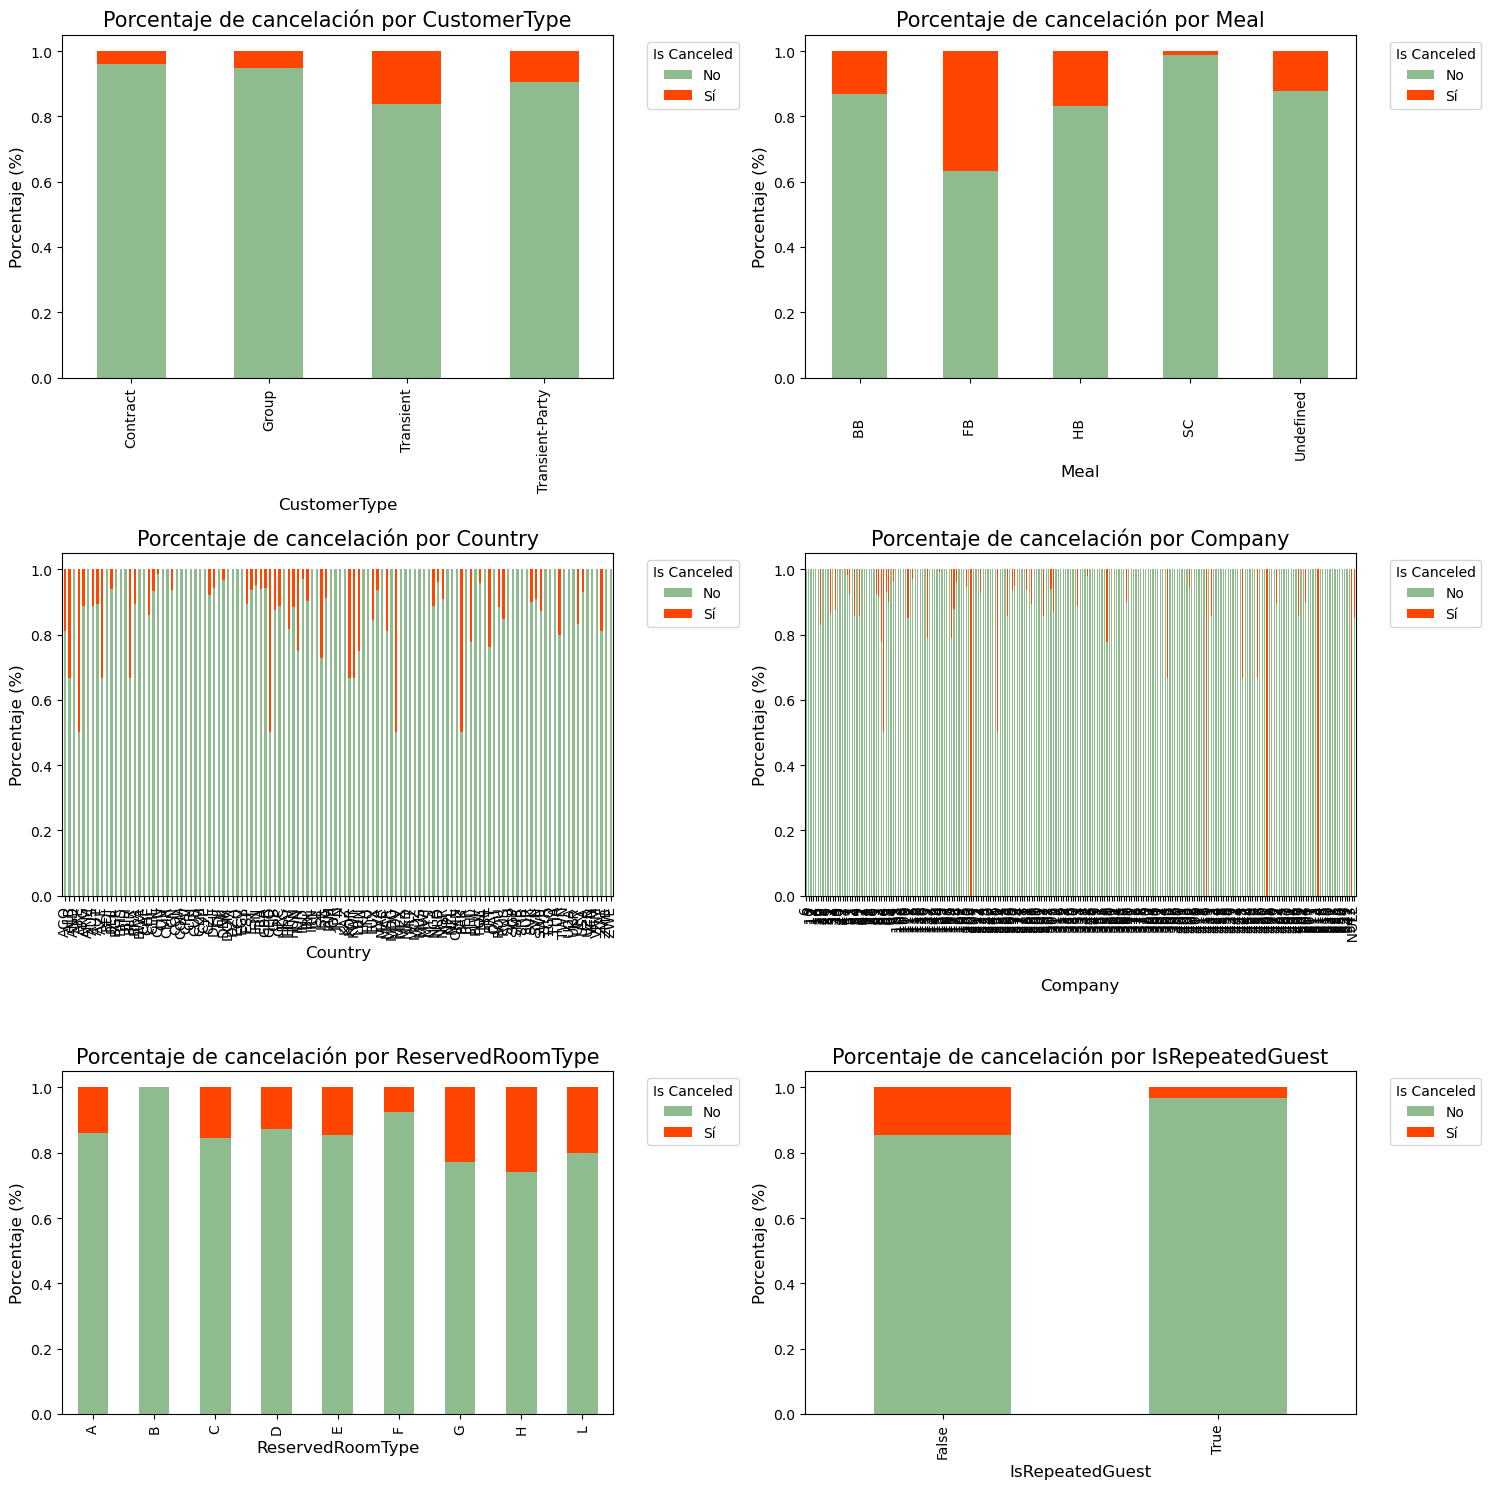

In [3]:
# Lista de variables categóricas
categorical_vars = ['CustomerType', 'Meal', 'Country', 'Company', 'ReservedRoomType', 'IsRepeatedGuest']

# Crear figura y ejes para los subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Colores para las barras
colors = ['darkseagreen', 'orangered']

# Iterar sobre las variables categóricas y crear un subplot para cada una
for var, ax in zip(categorical_vars, axes):
    # Crear una tabla cruzada normalizada por índice
    crosstab = pd.crosstab(df[var], df['IsCanceled'], normalize='index')
    
    # Crear el gráfico de barras apiladas
    crosstab.plot.bar(stacked=True, ax=ax, color=colors)
    
    # Configuración del gráfico
    ax.set_title(f'Porcentaje de cancelación por {var}', fontsize=15)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Porcentaje (%)', fontsize=12)
    ax.legend(title='Is Canceled', labels=['No', 'Sí'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()


In [186]:
df[categorical_vars].describe()

,CustomerType,Meal,Country,Company,ReservedRoomType,IsRepeatedGuest
count,33688,33688,33256,33688,33688,33688
unique,4,5,118,227,9,2
top,Transient,BB,PRT,NULL,A,False
freq,24818,25505,13385,30819,19760,31965


In [4]:
# Los paises con mayor cancelaciones de bookings
# Filtramos las filas donde IsCanceled es 1 (cancelación)
cancelaciones = df[df['IsCanceled'] == 1]
print("El numero total de cancelaciones es de:", cancelaciones.shape[0])

# Contamos las cancelaciones por país
cancelaciones_por_pais = cancelaciones['Country'].value_counts()
top_10_paises_cancelaciones = cancelaciones_por_pais.head(10)

# Los 10 paises con mayor Numero de cancelaciones totales
cancelaciones.groupby("Country").size().sort_values(ascending=False).head(10)

El numero total de cancelaciones es de: 4750


Country
PRT    3193
GBR     367
ESP     365
IRL     189
FRA      90
DEU      64
CHE      52
CN       42
BRA      39
ITA      36
dtype: int64

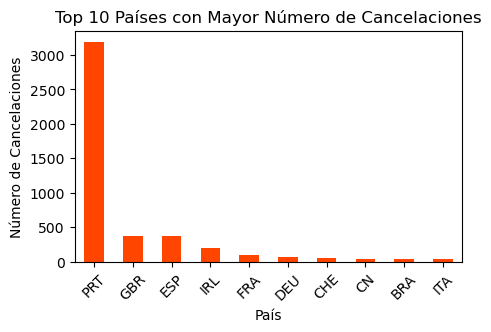

In [58]:
# hacemos un plot con los paises con mas cancelacion en este hotel
top_10_paises_cancelaciones.plot(kind='bar', color='orangered', figsize=(5, 3))
plt.title('Top 10 Países con Mayor Número de Cancelaciones')
plt.xlabel('País')
plt.ylabel('Número de Cancelaciones')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Top 10 Países con Mayor Número de Cancelaciones')

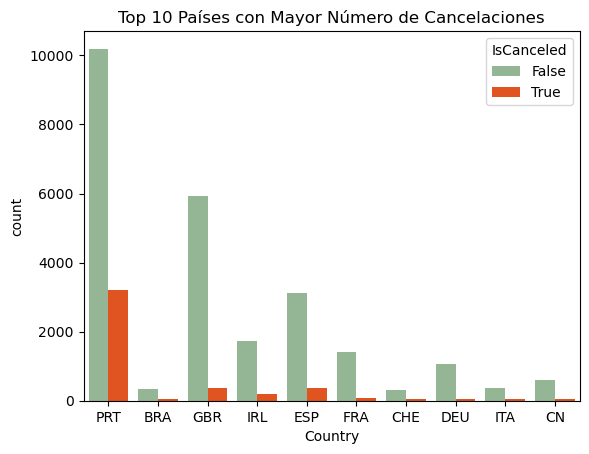

In [127]:
# Lista de países de interés
paises_interes = ['PRT', 'GBR', 'ESP', 'IRL', 'FRA', 'DEU', 'CHE', 'CN', 'BRA', 'ITA']

# Filtrar el dataset
clientes_paises_interes = df[df['Country'].isin(paises_interes)]

sns.countplot(x='Country', data=clientes_paises_interes, hue="IsCanceled", palette=colors)
plt.title('Top 10 Países con Mayor Número de Cancelaciones')


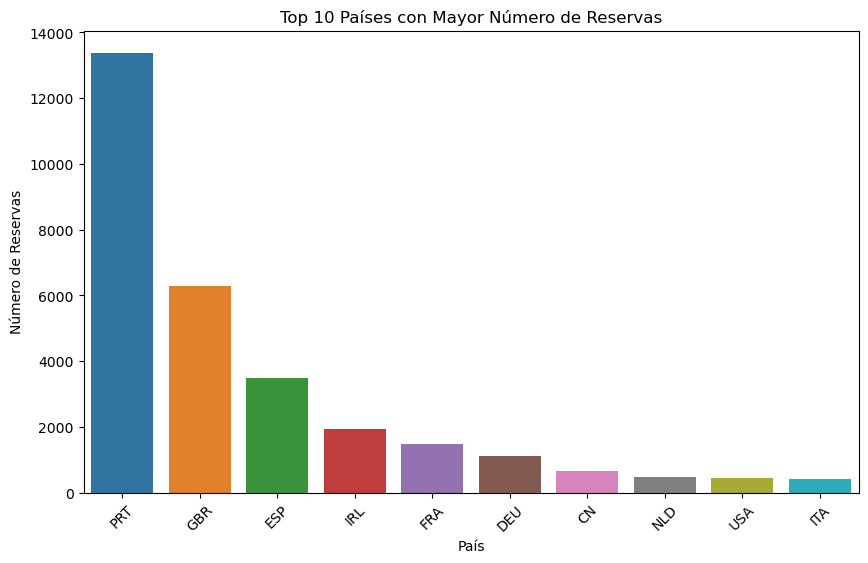

In [136]:
# Contamos las reservas por país
reservas_pais = df['Country'].value_counts()
top_10_reservas_pais = reservas_pais.head(10)

# Convertimos la serie en un DataFrame
df_reservas_pais = reservas_pais.reset_index()
df_reservas_pais.columns = ['Country', 'Count']

# Graficamos el top 10 de países con mayor número de reservas
plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Count', data=df_reservas_pais.head(10))
plt.title('Top 10 Países con Mayor Número de Reservas')
plt.xlabel('País')
plt.ylabel('Número de Reservas')
plt.xticks(rotation=45)
plt.show()


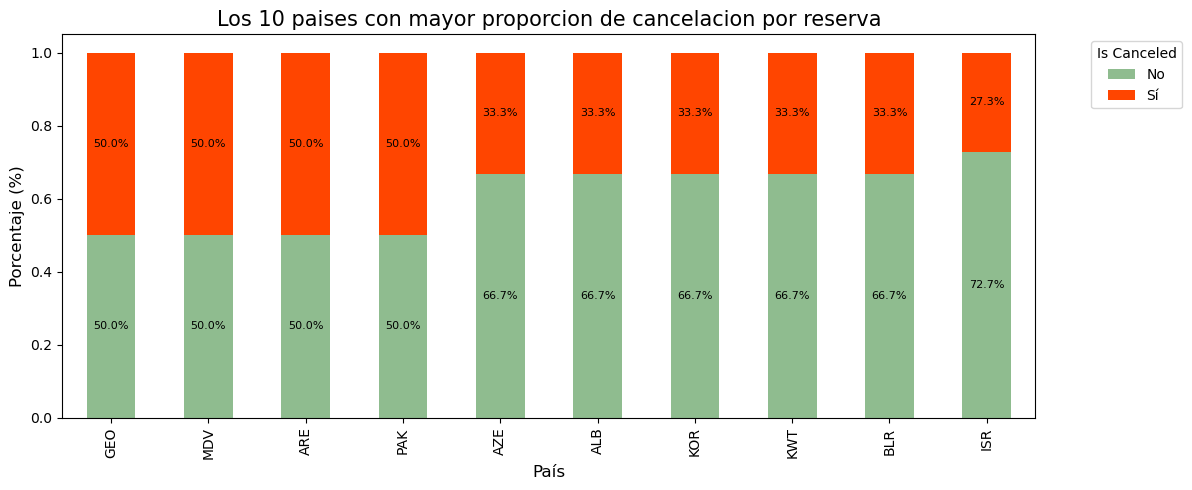

In [39]:
# Los 10 paises con mayor proporcion de cancelacion por reserva

# Ordenar los datos por el porcentaje de cancelaciones (columna 'Sí' en crosstab)
# Crear una tabla cruzada normalizada por índice para la variable 'Country'
crosstab = pd.crosstab(df['Country'], df_filtrado['IsCanceled'], normalize='index')
crosstab = crosstab.sort_values(by=True, ascending=False)

# Seleccionar los 10 países con la mayor proporción de cancelaciones
top_10_paises = crosstab.head(10)

# Crear figura y ejes para el subplot
fig, ax = plt.subplots(figsize=(12, 5))

# Colores para las barras
colors = ['darkseagreen', 'orangered']

# Crear el gráfico de barras apiladas
top_10_paises.plot.bar(stacked=True, ax=ax, color=colors)

# Agregar porcentajes dentro de las barras
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Para evitar etiquetas en barras de altura cero
        ax.text(x + width / 2, y + height / 2, f'{height * 100:.1f}%', 
                ha='center', va='center', fontsize=8, color='black')

# Configuración del gráfico
ax.set_title('Los 10 paises con mayor proporcion de cancelacion por reserva', fontsize=15)
ax.set_xlabel('País', fontsize=12)
ax.set_ylabel('Porcentaje (%)', fontsize=12)
ax.legend(title='Is Canceled', labels=['No', 'Sí'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()


#### 1.1b Conteo de variables categoricas

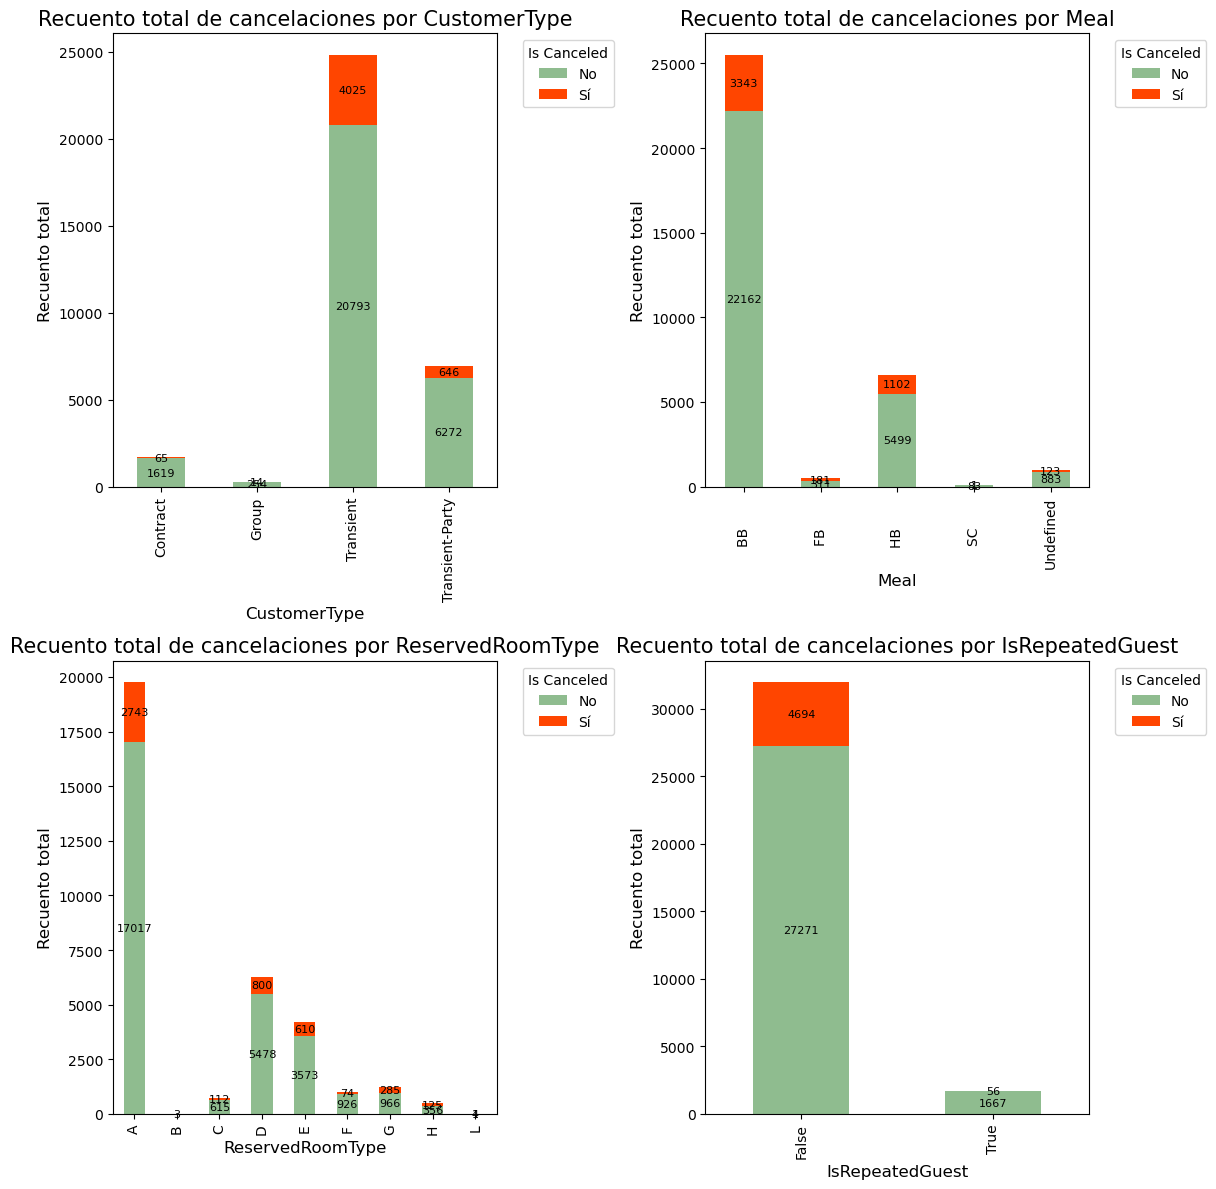

In [46]:
# Lista de variables categóricas
categorical_vars = ['CustomerType', 'Meal', 'ReservedRoomType', 'IsRepeatedGuest']

# Crear figura y ejes para los subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Colores para las barras
colors = ['darkseagreen', 'orangered']

# Iterar sobre las variables categóricas y crear un subplot para cada una
for var, ax in zip(categorical_vars, axes):
    # Crear una tabla cruzada sin normalizar
    crosstab = pd.crosstab(df[var], df['IsCanceled'])
    
    # Crear el gráfico de barras apiladas
    crosstab.plot.bar(stacked=True, ax=ax, color=colors)
    
    # Agregar etiquetas de recuento total en las barras
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height > 0:  # Para evitar etiquetas en barras de altura cero
            ax.text(x + width / 2, y + height / 2, f'{int(height)}', 
                    ha='center', va='center', fontsize=8, color='black')

    # Configuración del gráfico
    ax.set_title(f'Recuento total de cancelaciones por {var}', fontsize=15)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Recuento total', fontsize=12)
    ax.legend(title='Is Canceled', labels=['No', 'Sí'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

### 1.2 Variables numericas

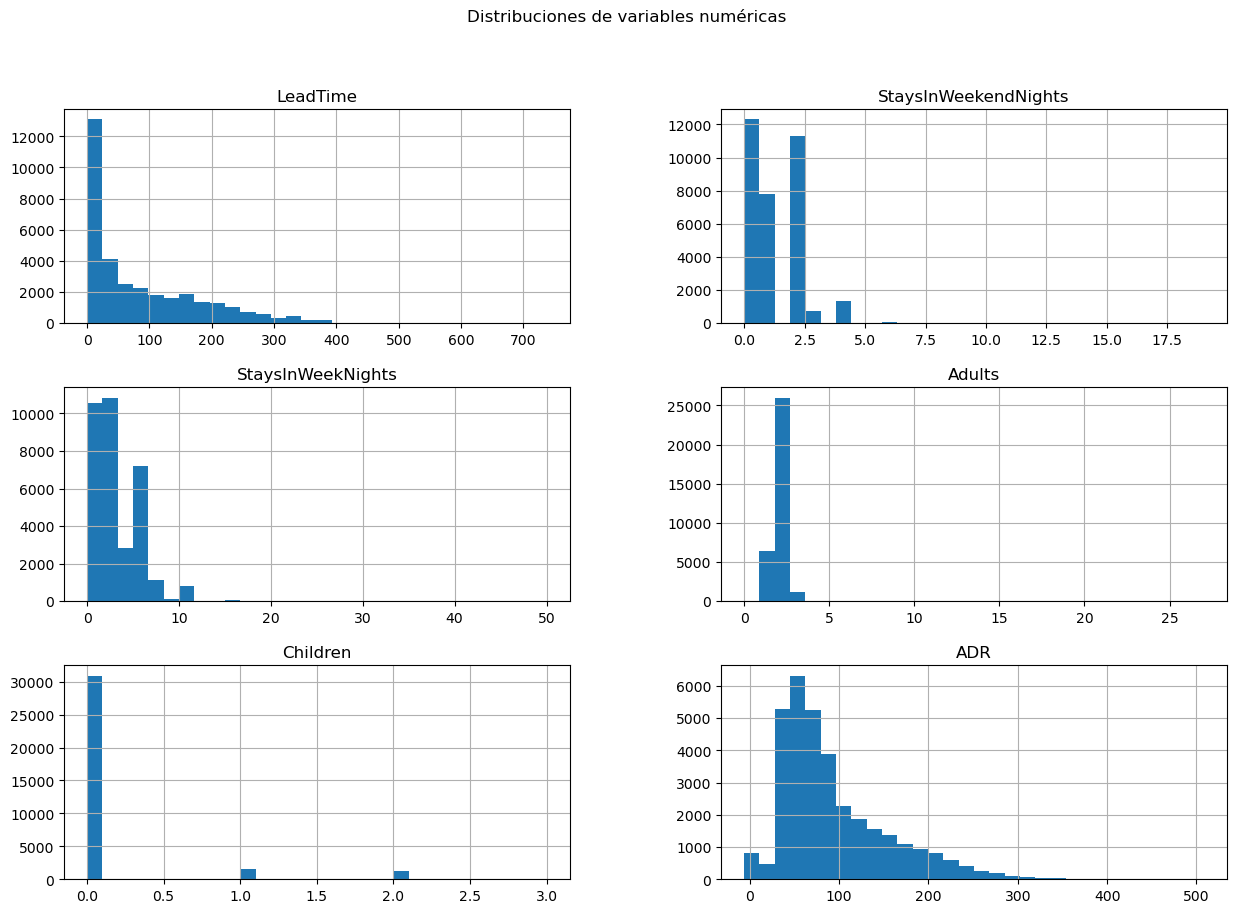

In [98]:
# Distribuciones de variables numéricas
numerical_vars = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'ADR']
df[numerical_vars].hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribuciones de variables numéricas')
plt.show()

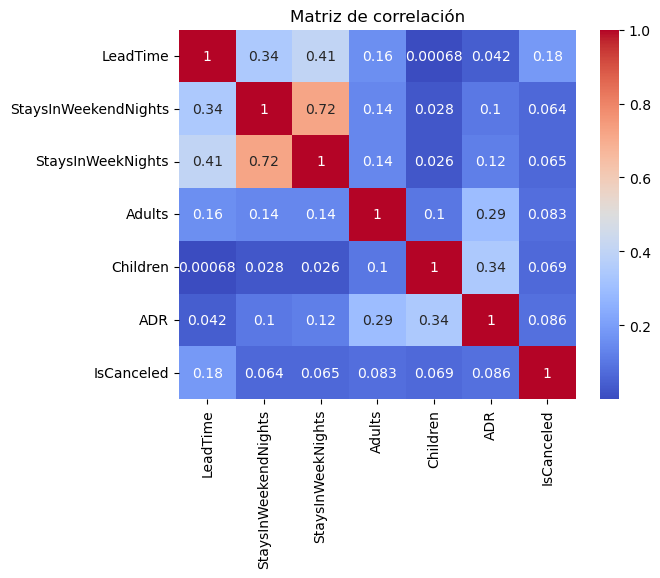

In [99]:
# correlacion de variables numericas con la variable target
corr_matrix = df[numerical_vars + ['IsCanceled']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

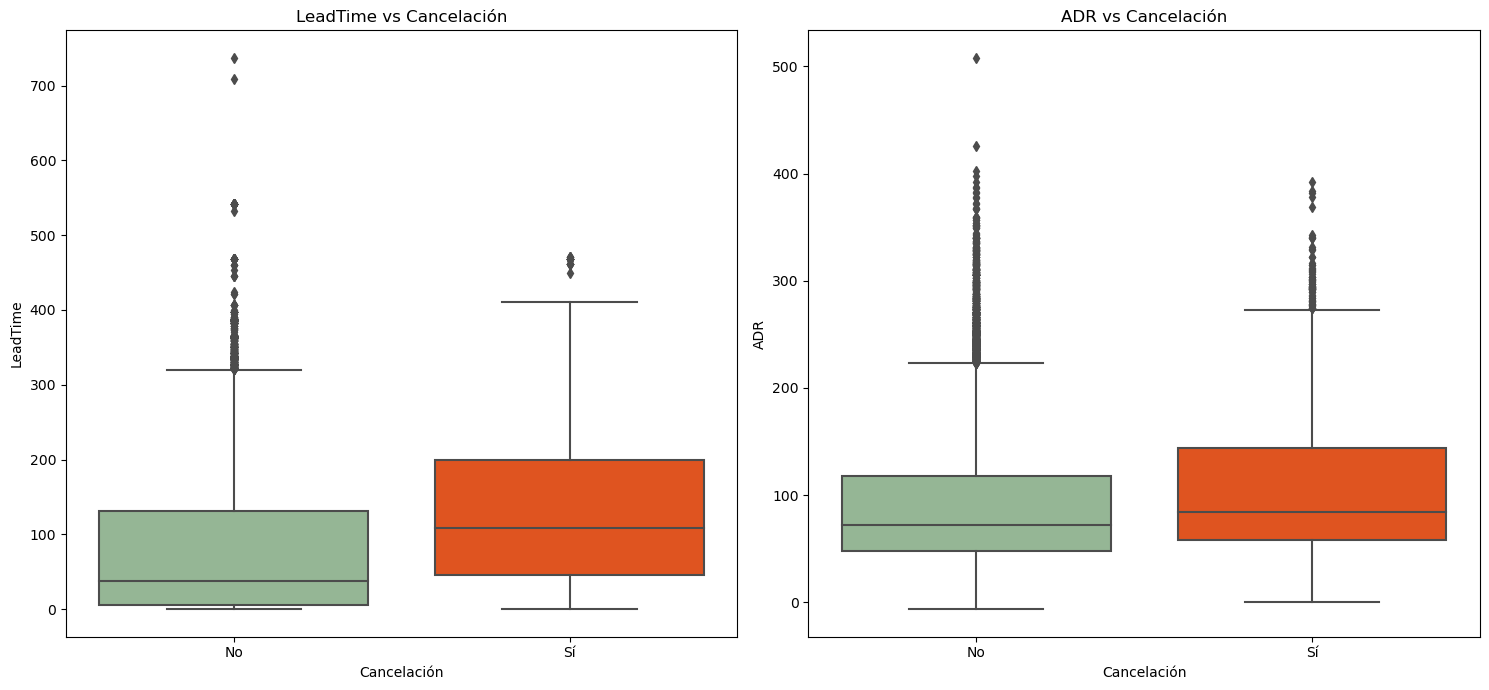

In [114]:
# Colores para las barras
colors = ['darkseagreen', 'orangered']

# Crear la figura y los ejes para los subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Crear boxplot para LeadTime
sns.boxplot(x='IsCanceled', y='LeadTime', data=df, palette=colors, ax=axes[0])
axes[0].set_title('LeadTime vs Cancelación')
axes[0].set_xlabel('Cancelación')
axes[0].set_ylabel('LeadTime')
axes[0].set_xticklabels(['No', 'Sí'])

# Crear boxplot para ADR
sns.boxplot(x='IsCanceled', y='ADR', data=df, palette=colors, ax=axes[1])
axes[1].set_title('ADR vs Cancelación')
axes[1].set_xlabel('Cancelación')
axes[1].set_ylabel('ADR')
axes[1].set_xticklabels(['No', 'Sí'])

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()

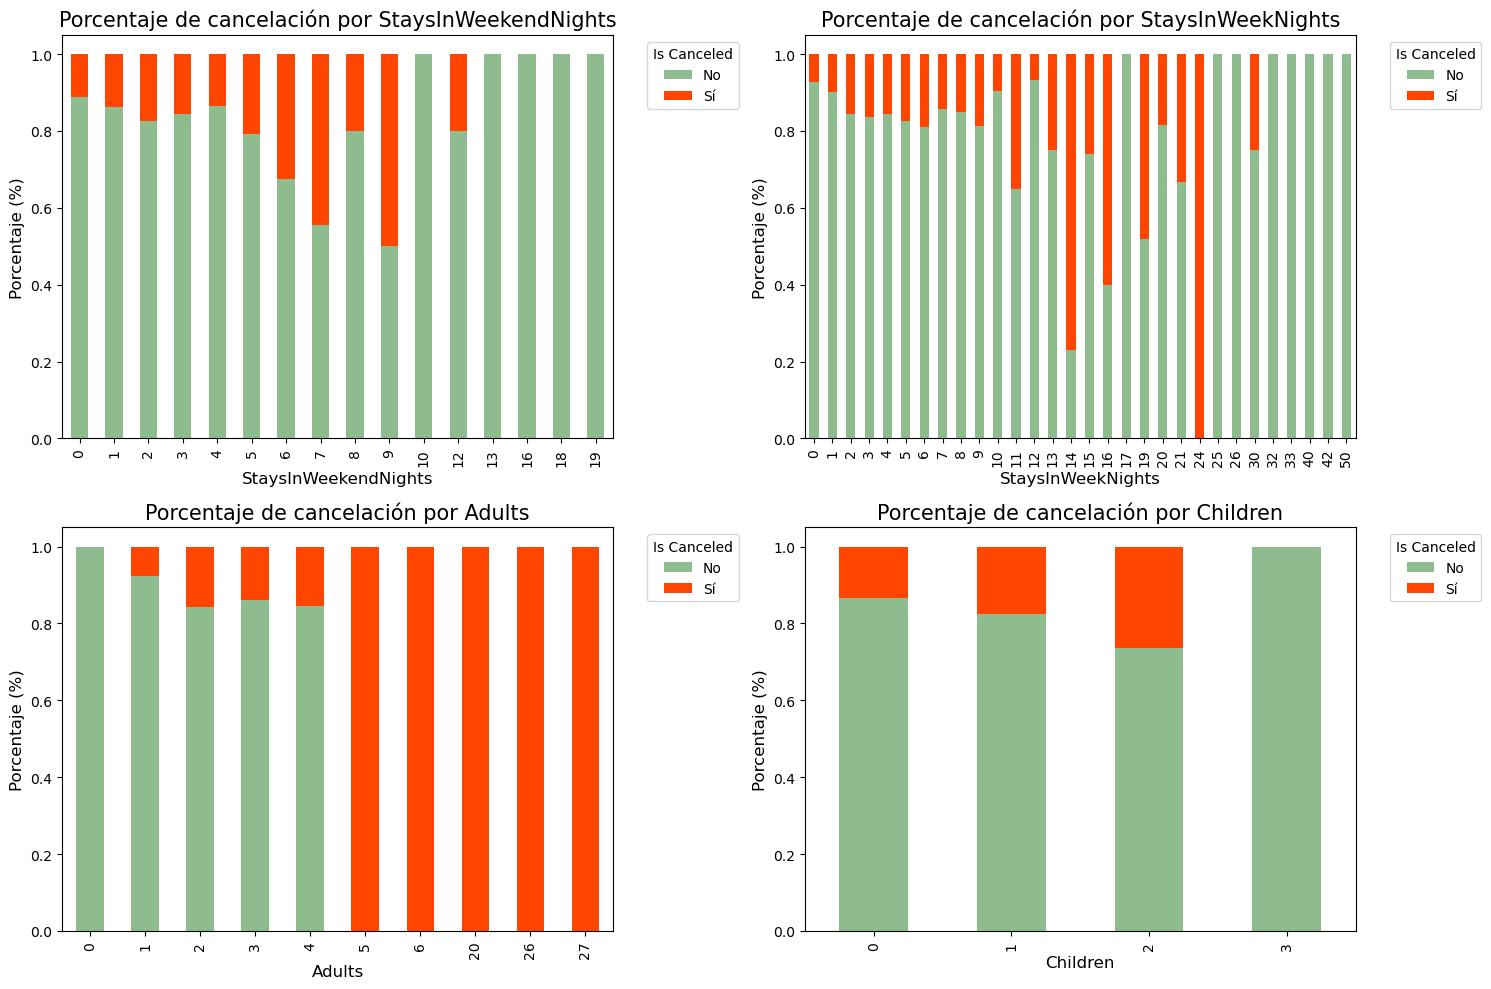

In [6]:
# Lista de variables numericas que podriamos transformar a categoricas
numerical_vars2 = ['StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children']

# Crear figura y ejes para los subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Colores para las barras
colors = ['darkseagreen', 'orangered']

# Iterar sobre las variables categóricas y crear un subplot para cada una
for var, ax in zip(numerical_vars2, axes):
    # Crear una tabla cruzada normalizada por índice
    crosstab = pd.crosstab(df[var], df['IsCanceled'], normalize='index')
    
    # Crear el gráfico de barras apiladas
    crosstab.plot.bar(stacked=True, ax=ax, color=colors)
    
    # # Agregar porcentajes dentro de las barras
    # for p in ax.patches:
    #     width, height = p.get_width(), p.get_height()
    #     x, y = p.get_xy()
    #     if height > 0:  # Para evitar etiquetas en barras de altura cero
    #         ax.text(x + width / 2, y + height / 2, f'{height * 100:.1f}%', 
    #                 ha='center', va='center', fontsize=8, color='black')
            
    # Configuración del gráfico
    ax.set_title(f'Porcentaje de cancelación por {var}', fontsize=15)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Porcentaje (%)', fontsize=12)
    ax.legend(title='Is Canceled', labels=['No', 'Sí'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()


#### 1.2b Variables temporales

In [8]:
# Convertir columnas de fecha a tipo datetime
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate'])

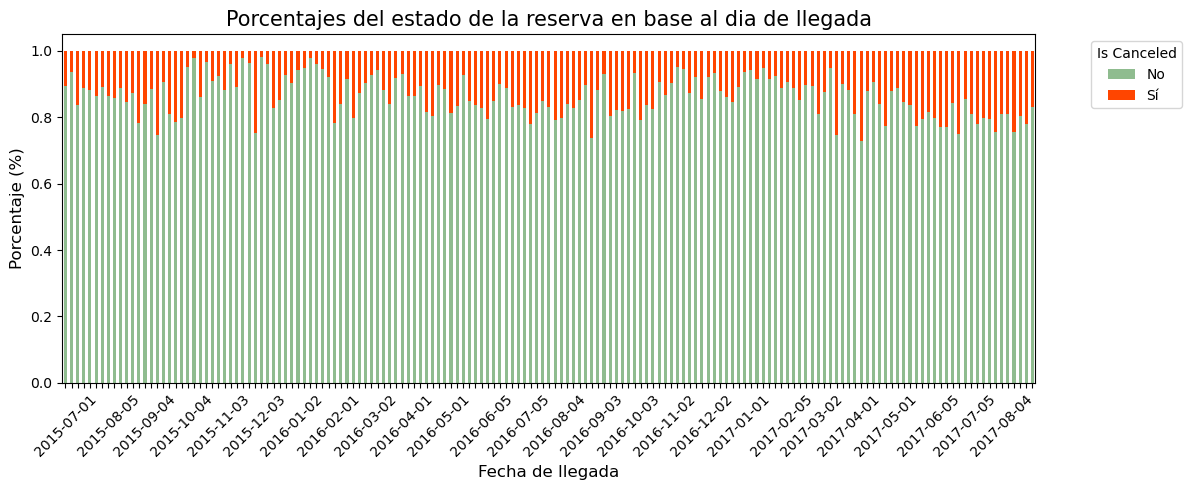

In [76]:
# Crear una nueva columna para los bins de 5 días
df['ArrivalDateBinned'] = pd.cut(df['ArrivalDate'], bins=pd.date_range(start=df['ArrivalDate'].min(), 
                                                                        end=df['ArrivalDate'].max() + pd.Timedelta(days=5), 
                                                                        freq='5D'))

# Crear una tabla cruzada normalizada por índice para la variable 'ArrivalDateBinned'
crosstab = pd.crosstab(df['ArrivalDateBinned'], df['IsCanceled'], normalize='index')

# Crear figura y ejes para el subplot
fig, ax = plt.subplots(figsize=(12, 5))

# Colores para las barras
colors = ['darkseagreen', 'orangered']

# Crear el gráfico de barras apiladas
crosstab.plot.bar(stacked=True, ax=ax, color=colors)

# Configuración del gráfico
ax.set_title('Porcentajes del estado de la reserva en base al dia de llegada', fontsize=15)
ax.set_xlabel('Fecha de llegada (agrupada cada 5 días)', fontsize=12)
ax.set_ylabel('Porcentaje (%)', fontsize=12)
ax.legend(title='Is Canceled', labels=['No', 'Sí'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar las etiquetas del eje x para mostrar solo una por mes
labels = [label.get_text() for label in ax.get_xticklabels()]
labels = [label.split(',')[0][1:] for label in labels]  # Extraer solo la primera fecha del bin
unique_months = []
unique_labels = []
for label in labels:
    month = label[:7]  # Extract year and month
    if month not in unique_months:
        unique_months.append(month)
        unique_labels.append(label)
    else:
        unique_labels.append('')

ax.set_xticklabels(unique_labels, rotation=45)

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

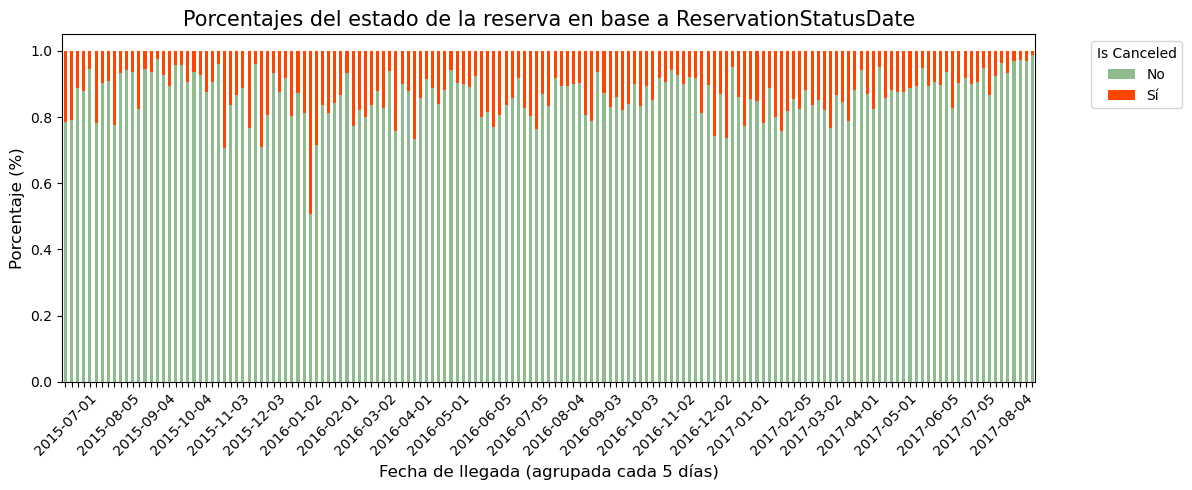

In [78]:
# Crear una nueva columna para los bins de 5 días
df['ArrivalDateBinned'] = pd.cut(df['ReservationStatusDate'], bins=pd.date_range(start=df['ArrivalDate'].min(), 
                                                                        end=df['ArrivalDate'].max() + pd.Timedelta(days=5), 
                                                                        freq='5D'))

# Crear una tabla cruzada normalizada por índice para la variable 'ArrivalDateBinned'
crosstab = pd.crosstab(df['ArrivalDateBinned'], df['IsCanceled'], normalize='index')

# Crear figura y ejes para el subplot
fig, ax = plt.subplots(figsize=(12, 5))

# Colores para las barras
colors = ['darkseagreen', 'orangered']

# Crear el gráfico de barras apiladas
crosstab.plot.bar(stacked=True, ax=ax, color=colors)

# Configuración del gráfico
ax.set_title('Porcentajes del estado de la reserva en base a ReservationStatusDate', fontsize=15)
ax.set_xlabel('Fecha de llegada (agrupada cada 5 días)', fontsize=12)
ax.set_ylabel('Porcentaje (%)', fontsize=12)
ax.legend(title='Is Canceled', labels=['No', 'Sí'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar las etiquetas del eje x para mostrar solo una por mes
labels = [label.get_text() for label in ax.get_xticklabels()]
labels = [label.split(',')[0][1:] for label in labels]  # Extraer solo la primera fecha del bin
unique_months = []
unique_labels = []
for label in labels:
    month = label[:7]  # Extract year and month
    if month not in unique_months:
        unique_months.append(month)
        unique_labels.append(label)
    else:
        unique_labels.append('')

ax.set_xticklabels(unique_labels, rotation=45)

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

### 1.3 Cancellation Rate - Proporciones de variable target

Vemos que hay un desbalance en la proporcion de los grupos del target, los bookings cancelados y no cancelados (14.1%/85.9%)

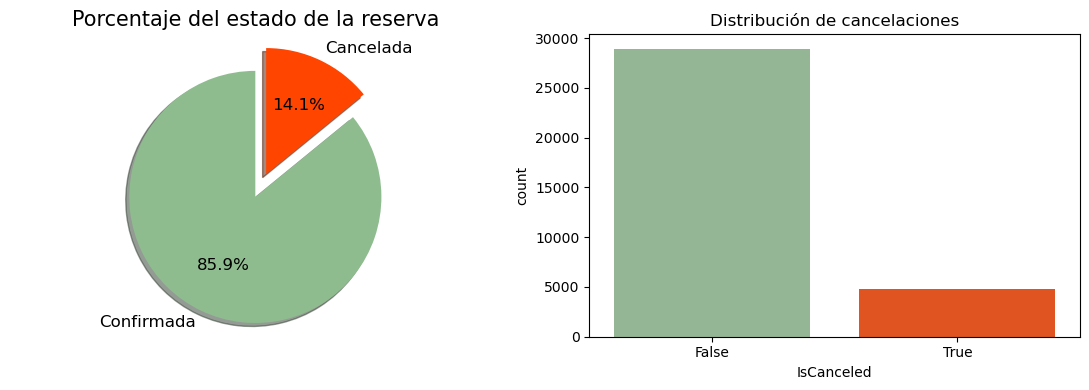

In [117]:
# Crear la figura y los ejes para los subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Etiquetas y colores personalizados para el gráfico de pastel
labels = ['Confirmada', 'Cancelada']
colors = ['darkseagreen', 'orangered']
myexplode = [0.2, 0]

# Crear el gráfico de pastel para el primer subplot
cancel_ax = axes[0]
cancel_ax.pie(
    df['IsCanceled'].value_counts(),
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    explode=myexplode,
    textprops={'color': "black", 'fontsize': 12},
    labels=labels,
    colors=colors
)
cancel_ax.axis('equal')
cancel_ax.set_title('Porcentaje del estado de la reserva', fontsize=15)

# Crear el gráfico de barras para el segundo subplot
count_ax = axes[1]
sns.countplot(x='IsCanceled', data=df, palette=colors, ax=count_ax)
count_ax.set_title('Distribución de cancelaciones')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()


## 2. Preparación de los datos

### ¿Le darías el mismo tratamiento a todas las variables?
 
No le daría el mismo tratamiento a todas las variables. Las variables categóricas necesitan ser transformadas en variables ficticias (dummies), y algunas de las variables numéricas podrían tratarse como variables categóricas, por lo que también tendríamos que convertirlas en variables dummies. 

Las variables numéricas deberíamos normalizarlas utilizando métodos como el logaritmo neperiano u otros métodos similares, para mejorar el rendimiento del modelo.

Por ultimo, las variables con fechas, no podemos utilizarlas directamente, sino que las transformaremos en características (features) numéricas que el modelo pueda entender.

 
### ¿Utilizarías todas las variables o eliminarías alguna de ellas por no ofrecer valor?

En primer lugar eliminaria las variables `Unnamed: 0` que suponemos sera el codigo del cliente y `HotelId` ya que solo tenemos un hotel. 

Despues, en base al EDA, podriamos eliminar `StaysInWeekendNights` porque tiene una alta correlacion con `StaysInWeekNights` y puede darnos problemas de multicolinealidad en el modelo. Sin embargo, estas dos se pueden agrupar en una como numero de noches por reserva (`total_stays`), y eliminaria las dos columnas anteriores.

De manera similar, `Adults` y `Children` se pueden agrupar en una nueva columna como numero de clientes totales (`Total_guests`)

La variable `Country` tiene mas de 200 nacionalidades, por ello, como el hotel esta en Lisboa, podemos agrupar los datos en nacionales (portugueses), y el resto como internacionales.

Las variables temporales `ReservationStatusDate` y `ArrivalDate` las transformaremos a numero de mes y numero de año (creando 4 variables de 2)

La variable (`Company`) tiene como dato mas frecuente 'NULL' (>30,000), por ello podemos clasificar en 2 grupos estos datos, reservas hechas por compañias (1), y reservas hechas de no compañias (0).

Para el resto, conservaría el resto de variables para mantener un modelo lo más completo posible. La decisión final de eliminar o conservar variables podria tomarse de nuevo después de evaluar la precisión y otras métricas del modelo o modelos.

.

In [251]:
# creamos una copia del dataframe
df_clean = df.copy()

# Nos quedamos con las variables de interes del dataframe
variables_elim = ["Unnamed: 0", "HotelId"]
df_clean = df.drop(columns=variables_elim)
#df_clean

### 2.1 Creamos variables nuevas

In [252]:
# Creamos la variable con el numero total de dias por estancia
df_clean['Total_stays'] = df_clean['StaysInWeekendNights'] + df_clean['StaysInWeekNights']

# Eliminar las variables utilizadas para crear la nueva columna
variables_eliminar = ['StaysInWeekendNights', 'StaysInWeekNights']
df_clean = df_clean.drop(columns=variables_eliminar)

df_clean.head()

,ReservationStatusDate,ArrivalDate,LeadTime,Adults,Children,CustomerType,ADR,Meal,Country,Company,ReservedRoomType,IsRepeatedGuest,IsCanceled,Total_stays
0,2016-12-15,2017-02-10,238,2,0,Transient,54.00,HB,PRT,NULL,A,False,True,2
1,2015-12-07,2016-05-27,174,2,1,Transient,108.02,BB,PRT,NULL,F,False,True,7
2,2015-08-24,2015-12-20,260,1,0,Transient,47.54,BB,PRT,NULL,D,False,True,13
3,2016-01-05,2016-04-12,168,2,0,Transient,86.00,HB,PRT,NULL,A,False,True,2
4,2015-11-11,2015-11-11,1,1,0,Transient,35.00,BB,PRT,88,A,True,True,1


In [9]:
#df_clean.Total_stays.value_counts()

In [253]:
# Creamos la variable Guests totales
df_clean['Total_guests'] = df_clean['Adults'] + df_clean['Children']

# Eliminar las variables utilizadas para crear la nueva columna
variables_eliminar = ['Adults', 'Children']
df_clean = df_clean.drop(columns=variables_eliminar)

df_clean.head()

,ReservationStatusDate,ArrivalDate,LeadTime,CustomerType,ADR,Meal,Country,Company,ReservedRoomType,IsRepeatedGuest,IsCanceled,Total_stays,Total_guests
0,2016-12-15,2017-02-10,238,Transient,54.00,HB,PRT,NULL,A,False,True,2,2
1,2015-12-07,2016-05-27,174,Transient,108.02,BB,PRT,NULL,F,False,True,7,3
2,2015-08-24,2015-12-20,260,Transient,47.54,BB,PRT,NULL,D,False,True,13,1
3,2016-01-05,2016-04-12,168,Transient,86.00,HB,PRT,NULL,A,False,True,2,2
4,2015-11-11,2015-11-11,1,Transient,35.00,BB,PRT,88,A,True,True,1,1


In [182]:
df_clean.Total_guests.value_counts()

Total_guests
2     23727
1      6311
3      2150
4      1454
5        29
0        11
26        3
20        1
27        1
6         1
Name: count, dtype: int64

In [254]:
# Paises resumidos en locales o internacionales
df_clean['guest_origin'] = df_clean['Country'].apply(lambda x: 'Local' if x == 'PRT' else 'International')

# Eliminar las variable utilizada para crear la nueva columna
variables_eliminar = ['Country']
df_clean = df_clean.drop(columns=variables_eliminar)

df_clean['guest_origin'].value_counts()


guest_origin
International    20303
Local            13385
Name: count, dtype: int64

In [255]:
# Tratamiento de las variables de fechas
## Reservation date
df_clean['Reservation_year'] = df_clean['ReservationStatusDate'].dt.year
df_clean['Reservation_month'] = df_clean['ReservationStatusDate'].dt.month

## Arrival date
df_clean['Arrival_year'] = df_clean['ArrivalDate'].dt.year
df_clean['Arrival_month'] = df_clean['ArrivalDate'].dt.month

# Eliminar las variable utilizada para crear la nueva columna
variables_eliminar = ['ReservationStatusDate', 'ArrivalDate']
df_clean = df_clean.drop(columns=variables_eliminar)

df_clean.head(10)


,LeadTime,CustomerType,ADR,Meal,Company,ReservedRoomType,IsRepeatedGuest,IsCanceled,Total_stays,Total_guests,guest_origin,Reservation_year,Reservation_month,Arrival_year,Arrival_month
0,238,Transient,54.00,HB,NULL,A,False,True,2,2,Local,2016,12,2017,2
1,174,Transient,108.02,BB,NULL,F,False,True,7,3,Local,2015,12,2016,5
2,260,Transient,47.54,BB,NULL,D,False,True,13,1,Local,2015,8,2015,12
3,168,Transient,86.00,HB,NULL,A,False,True,2,2,Local,2016,1,2016,4
4,1,Transient,35.00,BB,88,A,True,True,1,1,Local,2015,11,2015,11
5,145,Transient,100.80,BB,NULL,E,False,True,5,2,Local,2017,6,2017,6
6,17,Transient,155.00,BB,NULL,D,False,True,3,2,International,2017,6,2017,6
7,102,Transient-Party,50.00,HB,NULL,A,False,True,3,2,Local,2016,2,2016,2
8,25,Transient,46.40,BB,NULL,D,False,True,4,2,Local,2016,3,2016,3
9,219,Contract,93.50,BB,NULL,D,False,True,7,2,Local,2016,10,2017,6


In [256]:
# Transformamos la columna 'Company' donde 'NULL' se convierte en 0 y los demás valores en 1
# Eliminar espacios en blanco y comas de la columna 'Company'
df_clean['Company'] = df_clean['Company'].str.replace(',', '').str.strip()

# Verificar los valores únicos en la columna 'Company'
#print(df_clean['Company'].unique())

# Transformar la columna 'Company' donde 'NULL' se convierte en 0 y los demás valores en 1
df_clean['Company'] = df_clean['Company'].apply(lambda x: 0 if str(x).strip() == 'NULL' else 1)

# Contar los valores en la columna 'Company'
df_clean['Company'].value_counts()


Company
0    30819
1     2869
Name: count, dtype: int64

### 2.2 Preprocesamiento y preparacion de los datos

In [257]:
# Comprobamos valores nulos --> no hay ninguno
df_clean.isnull().sum()

LeadTime             0
CustomerType         0
ADR                  0
Meal                 0
Company              0
ReservedRoomType     0
IsRepeatedGuest      0
IsCanceled           0
Total_stays          0
Total_guests         0
guest_origin         0
Reservation_year     0
Reservation_month    0
Arrival_year         0
Arrival_month        0
dtype: int64

In [258]:
# Vamos a buscar datos erroneos
## ADR no puede tener ni valores negativos 
df_clean['ADR'].describe()

count    33688.000000
mean        92.892934
std         60.278815
min         -6.380000
25%         49.500000
50%         74.000000
75%        121.250000
max        508.000000
Name: ADR, dtype: float64

In [259]:
# Evaluamos valores anormales de ADR (<0)
df_clean[df_clean.ADR < 0]
# Eliminamos esta fila
df_clean.drop(df_clean[df_clean['ADR'] < 0].index, inplace = True)

In [260]:
# Evaluamos valores anormales de Total_guests (<=0)
df_clean[df_clean.Total_guests <= 0]
# Eliminamos estas filas
df_clean.drop(df_clean[df_clean['Total_guests'] <= 0].index, inplace = True)

In [264]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33676 entries, 0 to 33687
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LeadTime           33676 non-null  int64  
 1   CustomerType       33676 non-null  object 
 2   ADR                33676 non-null  float64
 3   Meal               33676 non-null  object 
 4   Company            33676 non-null  int64  
 5   ReservedRoomType   33676 non-null  object 
 6   IsRepeatedGuest    33676 non-null  bool   
 7   IsCanceled         33676 non-null  bool   
 8   Total_stays        33676 non-null  int64  
 9   Total_guests       33676 non-null  int64  
 10  guest_origin       33676 non-null  object 
 11  Reservation_year   33676 non-null  int32  
 12  Reservation_month  33676 non-null  int32  
 13  Arrival_year       33676 non-null  int32  
 14  Arrival_month      33676 non-null  int32  
dtypes: bool(2), float64(1), int32(4), int64(4), object(4)
memory usage: 3.1+ MB

#### Normalizacion - variables numericas

Para un XGBOOST no es extrictamente necesaria, pero puede ser beneficiosa.

In [266]:
from sklearn.preprocessing import StandardScaler

numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
df_clean[numeric_features] = scaler.fit_transform(df_clean[numeric_features])

In [267]:
df_clean

,LeadTime,CustomerType,ADR,Meal,Company,ReservedRoomType,IsRepeatedGuest,IsCanceled,Total_stays,Total_guests,guest_origin,Reservation_year,Reservation_month,Arrival_year,Arrival_month
0,1.590258,Transient,-0.645915,HB,-0.304937,A,False,True,-0.660262,0.043505,Local,-0.143789,1.693422,1.231013,-1.398283
1,0.920749,Transient,0.250475,BB,-0.304937,F,False,True,0.815439,1.442821,Local,-1.537637,1.693422,-0.157273,-0.468604
2,1.820402,Transient,-0.753110,BB,-0.304937,D,False,True,2.586281,-1.355810,Local,-1.537637,0.486034,-1.545558,1.700649
3,0.857982,Transient,-0.114918,HB,-0.304937,A,False,True,-0.660262,0.043505,Local,-0.143789,-1.626897,-0.157273,-0.778497
4,-0.889019,Transient,-0.961195,BB,3.279371,A,True,True,-0.955402,-1.355810,Local,-1.537637,1.391575,-1.545558,1.390756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33683,1.318270,Transient,-0.052691,BB,-0.304937,A,False,False,1.700860,1.442821,International,1.250060,0.787881,1.231013,0.461076
33684,0.868443,Transient-Party,1.814429,BB,-0.304937,E,False,False,1.996000,0.043505,International,1.250060,0.787881,1.231013,0.461076
33685,1.234581,Transient,1.006317,BB,-0.304937,E,False,False,2.881421,0.043505,International,1.250060,0.787881,1.231013,0.461076
33686,1.307809,Contract,0.329793,HB,-0.304937,D,False,False,2.881421,0.043505,International,1.250060,0.787881,1.231013,0.461076


#### One-Hot encoder (dummies) - variables categoricas

In [269]:
#Codificación One-Hot de Variables Categóricas
categorical_features = df_clean.select_dtypes(include=[object]).columns.tolist()
#categorical_features

df_clean = pd.get_dummies(df_clean, columns=categorical_features, drop_first=True)

In [270]:
df_clean

,LeadTime,ADR,Company,IsRepeatedGuest,IsCanceled,Total_stays,Total_guests,Reservation_year,Reservation_month,Arrival_year,...,Meal_Undefined,ReservedRoomType_B,ReservedRoomType_C,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,ReservedRoomType_H,ReservedRoomType_L,guest_origin_Local
0,1.590258,-0.645915,-0.304937,False,True,-0.660262,0.043505,-0.143789,1.693422,1.231013,...,False,False,False,False,False,False,False,False,False,True
1,0.920749,0.250475,-0.304937,False,True,0.815439,1.442821,-1.537637,1.693422,-0.157273,...,False,False,False,False,False,True,False,False,False,True
2,1.820402,-0.753110,-0.304937,False,True,2.586281,-1.355810,-1.537637,0.486034,-1.545558,...,False,False,False,True,False,False,False,False,False,True
3,0.857982,-0.114918,-0.304937,False,True,-0.660262,0.043505,-0.143789,-1.626897,-0.157273,...,False,False,False,False,False,False,False,False,False,True
4,-0.889019,-0.961195,3.279371,True,True,-0.955402,-1.355810,-1.537637,1.391575,-1.545558,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33683,1.318270,-0.052691,-0.304937,False,False,1.700860,1.442821,1.250060,0.787881,1.231013,...,False,False,False,False,False,False,False,False,False,False
33684,0.868443,1.814429,-0.304937,False,False,1.996000,0.043505,1.250060,0.787881,1.231013,...,False,False,False,False,True,False,False,False,False,False
33685,1.234581,1.006317,-0.304937,False,False,2.881421,0.043505,1.250060,0.787881,1.231013,...,False,False,False,False,True,False,False,False,False,False
33686,1.307809,0.329793,-0.304937,False,False,2.881421,0.043505,1.250060,0.787881,1.231013,...,False,False,False,True,False,False,False,False,False,False


In [272]:
#Conversión de Variables Booleanas a 0 y 1:
boolean_features = df_clean.select_dtypes(include=[bool]).columns.tolist()
boolean_features

df_clean[boolean_features] = df_clean[boolean_features].astype(int)


In [273]:
df_clean

,LeadTime,ADR,Company,IsRepeatedGuest,IsCanceled,Total_stays,Total_guests,Reservation_year,Reservation_month,Arrival_year,...,Meal_Undefined,ReservedRoomType_B,ReservedRoomType_C,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,ReservedRoomType_H,ReservedRoomType_L,guest_origin_Local
0,1.590258,-0.645915,-0.304937,0,1,-0.660262,0.043505,-0.143789,1.693422,1.231013,...,0,0,0,0,0,0,0,0,0,1
1,0.920749,0.250475,-0.304937,0,1,0.815439,1.442821,-1.537637,1.693422,-0.157273,...,0,0,0,0,0,1,0,0,0,1
2,1.820402,-0.753110,-0.304937,0,1,2.586281,-1.355810,-1.537637,0.486034,-1.545558,...,0,0,0,1,0,0,0,0,0,1
3,0.857982,-0.114918,-0.304937,0,1,-0.660262,0.043505,-0.143789,-1.626897,-0.157273,...,0,0,0,0,0,0,0,0,0,1
4,-0.889019,-0.961195,3.279371,1,1,-0.955402,-1.355810,-1.537637,1.391575,-1.545558,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33683,1.318270,-0.052691,-0.304937,0,0,1.700860,1.442821,1.250060,0.787881,1.231013,...,0,0,0,0,0,0,0,0,0,0
33684,0.868443,1.814429,-0.304937,0,0,1.996000,0.043505,1.250060,0.787881,1.231013,...,0,0,0,0,1,0,0,0,0,0
33685,1.234581,1.006317,-0.304937,0,0,2.881421,0.043505,1.250060,0.787881,1.231013,...,0,0,0,0,1,0,0,0,0,0
33686,1.307809,0.329793,-0.304937,0,0,2.881421,0.043505,1.250060,0.787881,1.231013,...,0,0,0,1,0,0,0,0,0,0


## 3. Construcción del modelo

* ¿Qué tipo de modelo es el más adiente? Support Vector Machines, Decision Tree, Logistic Regression, K-Means, Redes Neuronales, Random Forest, Gradient Boosting, Naive Bayes, PCA, Lasso Regression... 

Observamos que tenemos un problema de clases desbalanceadas, con menos cancelaciones, que representan el 14% del total de reservas. Por este motivo, a la hora de escoger un algoritmo de machine learning, nos vamos a decantar por el xgboost. Es un algoritmo muy eficiente en problemas de clases desbalanceadas. Esto se debe a que el boosting tiene más en cuenta los errores, por lo que es una manera de tratar las clases menos repetidas. Tampoco vamos a requerir estandarizar los datos al ser un modelo basado en árboles de decisión. Se trata de un método que reduce el sesgo. Admás no es sensible a atípicos.

Las principales razones para elegir este modelo son los siguiente:
- Es robusto a las clases desbalanceadas.
- Maneja tanto variables numéricas como categóricas.
- Proporciona interpretabilidad mediante la importancia de características.


### Evaluación del Modelo
- **Benchmark**: Una precisión y una AUC ROC superiores a 0.5 indican que el modelo es mejor que el azar.

El modelo utilizado presenta un buen rendimiento en ambos conjuntos de datos, con un accuracy cercano al 98% en el conjunto de entrenamiento y al 97% en el conjunto de prueba. Aunque hay una ligera diferencia entre ambos valores, lo que podría sugerir una leve tendencia al overfitting, esta discrepancia es aceptable y no representa una preocupación significativa. Es importante seguir monitoreando el modelo para detectar posibles problemas de overfitting a medida que se ajusta y se aplican técnicas adicionales de validación. En general, un ROC AUC mayor que 0.8 se considera bueno, por lo que un valor de 0.89 indica un rendimiento sólido del modelo


- **Resultados en Producción**: Con un buen modelo en producción, se espera reducir las cancelaciones efectivas al realizar overbooking de manera precisa.

Este modelo clasifica si una reserva se cancelará o no con una precisión de hasta el 97%. Como resultado permite a los hoteles estimar sus tasas de ocupación de forma más cuantificable, gestionar su negocio adecuadamente y aumentar aún más sus ingresos.

Los riesgos de este modelo son los siguientes (basado en los datos de confusion matrix):

- 3% de posibilidades de que el hotel prediga que no se cancela una reserva, y finalmente la reserva saldrá mal (reserva cancelada).
- 2% de posibilidades de que el hotel no prediga/sospeche que la reserva se cancelara, y finalmente no se cancela, con el riesgo de overbooking. En estos casos, este % de reservas sera facilmente asumible por otros hoteles del mismo grupo en la ciudad de Lisboa.

Basado en la Importancia de las Características del modelo XGBOOST, los 5 factores principales que afectan a que las reservas de hotel se cancelen o no son:

- 1. El origen del huesped sea "Local" (Portugues)
- 2. El tipo de cliente sea "Transient"
- 3. El mes en el que se hace la reserva
- 4. El mes de llegada del cliente (arrival month)
- 5. El año en el que se hizo la reserva 

Como vemos, estas caracteristicas no las hemos podido observar a simple vista en el EDA. 

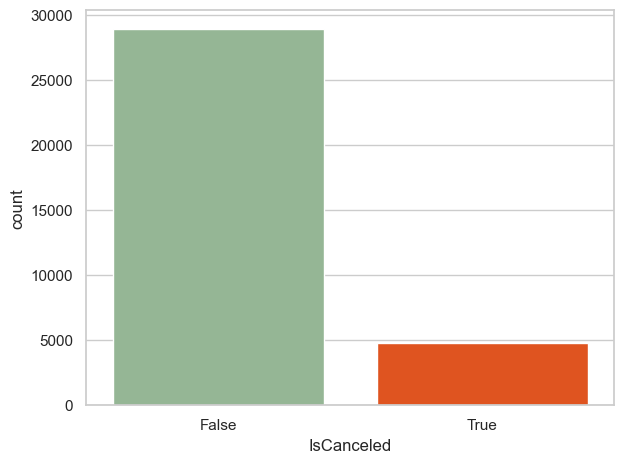

In [263]:
# Etiquetas y colores personalizados para el gráfico de pastel
labels = ['Confirmada', 'Cancelada']
colors = ['darkseagreen', 'orangered']
sns.countplot(x='IsCanceled', data=df, palette=colors)
count_ax.set_title('Distribución de cancelaciones')
# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

In [274]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score

# Separación en variables predictoras y objetivo
X = df_clean.drop(columns=['IsCanceled'])
y = df_clean['IsCanceled']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluación del modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5797
           1       0.98      0.78      0.87       939

    accuracy                           0.97      6736
   macro avg       0.97      0.89      0.92      6736
weighted avg       0.97      0.97      0.97      6736

[[5780   17]
 [ 206  733]]
ROC AUC Score: 0.8888425635308043
Accuracy: 0.9668942992874109


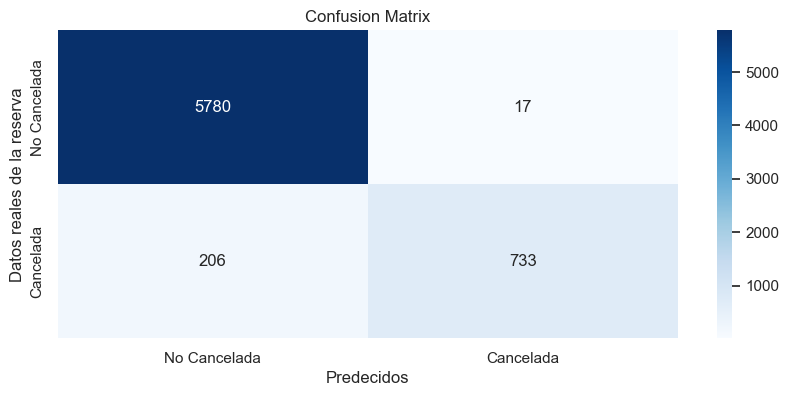

In [283]:
# Evaluación del modelo
y_pred = model.predict(X_test)

# Clasification Report
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar la Matriz de Confusión con un gráfico de Seaborn
plt.figure(figsize=(10, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Modificar etiquetas de los ejes x e y
tick_labels = ['No Cancelada', 'Cancelada']  # Nuevas etiquetas
plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)  # Modificar etiquetas del eje x
plt.yticks(ticks=[0.5, 1.5], labels=tick_labels)  # Modificar etiquetas del eje y

plt.xlabel('Predecidos')
plt.ylabel('Datos reales de la reserva')
plt.title('Confusion Matrix')
plt.show()


In [289]:
# vamos a evaluar el overfitting
# Predecir en el conjunto de entrenamiento y calcular el accuracy
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predecir en el conjunto de prueba y calcular el accuracy
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Accuracy en el conjunto de entrenamiento: {train_accuracy:.2}')
print(f'Accuracy en el conjunto de prueba: {test_accuracy:.2}')

Accuracy en el conjunto de entrenamiento: 0.98
Accuracy en el conjunto de prueba: 0.97


Para un modelo XGBoost, podemos calcular las características más importantes para la clase "true" del target feature (predicción de cancelaciones) siguiendo estos pasos:

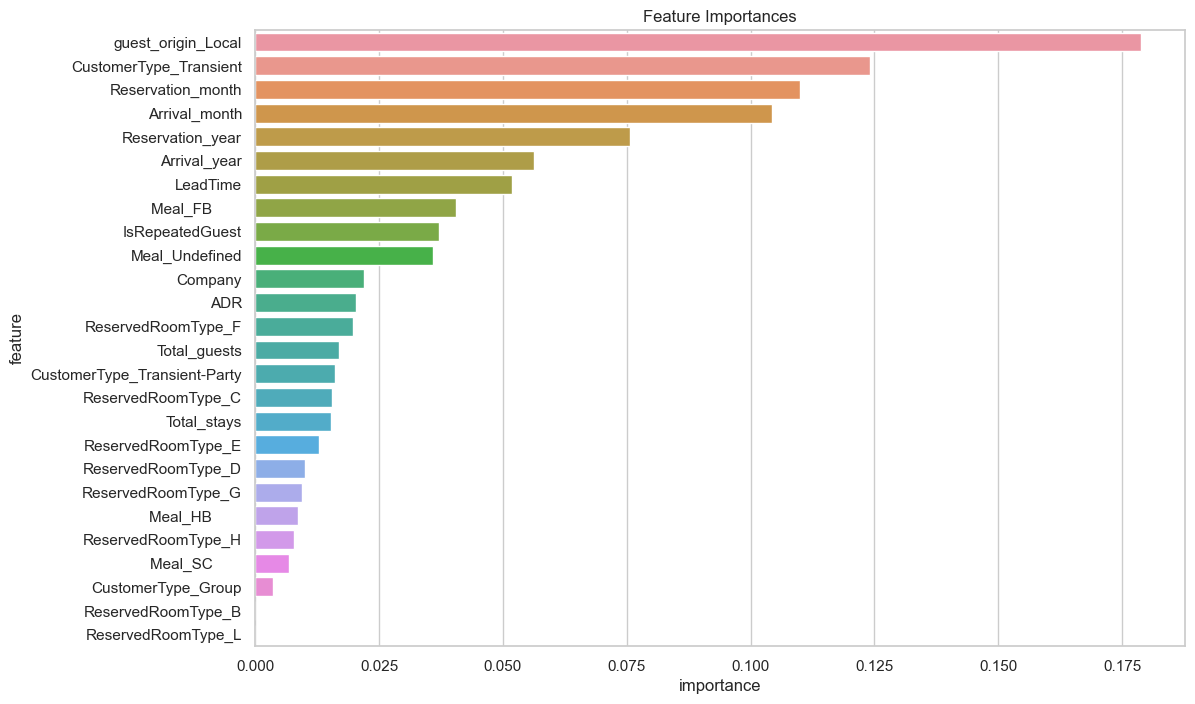

In [280]:
# Obtener las características más importantes
importances = model.feature_importances_
features = X.columns

# Crear un DataFrame con las características y sus importancias
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Ordenar el DataFrame por importancia
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Visualizar las características más importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()